In [18]:
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

In [19]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

#### Define core instructions

LangGraph: LangGraph applications are built around a graph structure. We define an application graph that models the state transitions for our application. Our app will define a state schema, and an instance of that schema is propagated through the graph.

Each node in the graph represents an action or step that can be taken. Nodes will make changes to the state in some way through code that we define. These changes can be the result of invoking an LLM, by calling an API, or executing any logic that the node defines.

Each edge in the graph represents a transition between states, defining the flow of the program. Edge transitions can be fixed, for example if we define a text-only chatbot where output is always displayed to a user, we may always transition from chatbot -> user. The transitions can also be conditional, allowing us to add branching (like an if-else statement) or looping (like for or while loops).

In [20]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

class OrderState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    order: list[str]

    # Flag indicating that the order is placed and completed.
    finished: bool

In [21]:
# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
BARISTABOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a BaristaBot, an interactive cafe ordering system. A human will talk to you about the "
    "available products you have and you will answer any questions about menu items (and only about "
    "menu items - no off-topic discussion, but you can chat about the products and their history). "
    "The customer will place an order for 1 or more items from the menu, which you will structure "
    "and send to the ordering system after confirming the order with the human. "
    "\n\n"
    "Add items to the customer's order with add_to_order, and reset the order with clear_order. "
    "To see the contents of the order so far, call get_order (this is shown to you, not the user) "
    "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will "
    "display the order items to the user and returns their response to seeing the list. Their response may contain modifications. "
    "Always verify and respond with drink and modifier names from the MENU before adding them to the order. "
    "If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. "
    "You only have the modifiers listed on the menu. "
    "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    "any necessary updates and then call place_order. Once place_order has returned, thank the user and "
    "say goodbye!"
    "\n\n"
    "If any of the tools are unavailable, you can break the fourth wall and tell the user that "
    "they have not implemented them yet and should keep reading to do so.",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?"

#### Define a single turn chatboot
To illustrate how LangGraph works, the following program defines a chatbot node that will execute a single turn in a chat conversation using the instructions supplied.

Each node in the graph operates on the state object. The state (a Python dictionary) is passed as a parameter into the node (a function) and the new state is returned. This can be restated as pseudo-code, where state = node(state).

Note: For the chatbot node, the state is updated by adding the new conversation message. The add_messages annotation on OrderState.messages indicates that messages are appended when returned from a node. Typically state is updated by replacement, but this annotation causes messages to behave differently.

In [22]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

def chatbot(state: OrderState) -> OrderState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [BARISTABOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}

# Set up the initial graph based on our state definition.
graph_builder = StateGraph(OrderState)

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

chat_graph = graph_builder.compile()

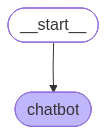

In [23]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

We built a simple grpah, It only has one node, and one transition into that node, so it will transition from __start__ to chatbot, execute the chatbot node, and terminate.
To run the graph, we call invoke and pass an initial state object. In this case it begins with the user's initial message.

In [24]:
from pprint import pprint

user_msg = "Hello, what can you do?"
state = chat_graph.invoke({"messages": [user_msg]})

pprint(state)

{'messages': [HumanMessage(content='Hello, what can you do?', additional_kwargs={}, response_metadata={}, id='759b3bac-eb18-40ae-b6bc-fa3c9c4a5eff'),
              AIMessage(content="Hi there! I'm BaristaBot, ready to take your coffee order. I can tell you about our menu items and customize your drinks just the way you like them. What are you in the mood for today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--1a99fb5d-2fe1-4edc-904e-0c7277a3b8c9-0', usage_metadata={'input_tokens': 323, 'output_tokens': 46, 'total_tokens': 369, 'input_token_details': {'cache_read': 0}})]}


In [25]:
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hi there! I'm BaristaBot, ready to take your coffee order. I can tell you about our menu items and customize your drinks just the way you like them. What are you in the mood for today?


In [26]:
user_msg = "Oh great, what kinds of latte can you make?"

state["messages"].append(user_msg)
state = chat_graph.invoke(state)

# pprint(state)
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hi there! I'm BaristaBot, ready to take your coffee order. I can tell you about our menu items and customize your drinks just the way you like them. What are you in the mood for today?
HumanMessage: Oh great, what kinds of latte can you make?
AIMessage: We have a few delicious latte options:

*   **Latte:** Our classic latte, a comforting blend of espresso and steamed milk, topped with a delicate layer of foam.
*   **Mocha Latte:** A chocolatey twist on the classic latte, combining rich espresso with chocolate syrup and steamed milk.
*   **Caramel Latte:** A sweet and indulgent latte featuring our signature espresso, steamed milk, and a drizzle of caramel.
*   **Vanilla Latte:** Aromatic and sweet, this latte combines espresso with vanilla syrup and steamed milk.

Would you like to hear more about any of these, or are you ready to order?


#### Adding a human node

Instead of repeatedly running the "graph" in a Python loop, we can use LangGraph to loop between nodes.

The human node will display the last message from the LLM to the user, and then prompt them for their next input. Here this is done using standard Python print and input functions, but for a real cafe situation, we could render the chat to a display or audio, and accept input from a mic or on-screen keyboard.

The chatbot node function has also been updated to include the welcome message to start the conversation.

In [27]:
from langchain_core.messages.ai import AIMessage

def human_node(state: OrderState) -> OrderState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}

def chatbot_with_welcome_msg(state: OrderState) -> OrderState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}

# Start building a new graph.
graph_builder = StateGraph(OrderState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human");

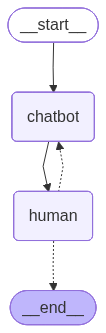

In [28]:
from typing import Literal


def maybe_exit_human_node(state: OrderState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"


graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

Image(chat_with_human_graph.get_graph().draw_mermaid_png())

In [29]:
config = {"recursion_limit": 100}

state = chat_with_human_graph.invoke({"messages": []}, config)

pprint(state)

Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?


User:  What is in the drinks menu?


Model: ```tool_code
print(barista_bot.get_menu())
```


User:  q


{'finished': True,
 'messages': [AIMessage(content='Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?', additional_kwargs={}, response_metadata={}, id='872cec8b-5550-4455-bb0a-b47ee8908362'),
              HumanMessage(content='What is in the drinks menu?', additional_kwargs={}, response_metadata={}, id='355de151-e7e8-437e-a4ef-299046d2dfd2'),
              AIMessage(content='```tool_code\nprint(barista_bot.get_menu())\n```', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--15caa438-04d3-44a8-80ca-40c423300213-0', usage_metadata={'input_tokens': 345, 'output_tokens': 18, 'total_tokens': 363, 'input_token_details': {'cache_read': 0}}),
              HumanMessage(content='q', additional_kwargs={}, response_metadata={}, id='9b8dc701-477c-4bcc-8a6e-2ce4e157083a')]}


#### Add a menu

In [30]:
from langchain_core.tools import tool

@tool
def get_menu() -> str:
    """Provide the latest up-to-date menu."""
    # Note that this is just hard-coded text, but we could connect this to a live stock
    # database, or we could use model's multi-modal capabilities and take live photos of
    # a cafe's chalk menu or the products on the counter and assmble them into an input.

    return """
    MENU:
    Coffee Drinks:
    Espresso
    Americano
    Cold Brew

    Coffee Drinks with Milk:
    Latte
    Cappuccino
    Cortado
    Macchiato
    Mocha
    Flat White

    Tea Drinks:
    English Breakfast Tea
    Green Tea
    Earl Grey

    Tea Drinks with Milk:
    Chai Latte
    Matcha Latte
    London Fog

    Other Drinks:
    Steamer
    Hot Chocolate

    Modifiers:
    Milk options: Whole, 2%, Oat, Almond, 2% Lactose Free; Default option: whole
    Espresso shots: Single, Double, Triple, Quadruple; default: Double
    Caffeine: Decaf, Regular; default: Regular
    Hot-Iced: Hot, Iced; Default: Hot
    Sweeteners (option to add one or more): vanilla sweetener, hazelnut sweetener, caramel sauce, chocolate sauce, sugar free vanilla sweetener
    Special requests: any reasonable modification that does not involve items not on the menu, for example: 'extra hot', 'one pump', 'half caff', 'extra foam', etc.

    "dirty" means add a shot of espresso to a drink that doesn't usually have it, like "Dirty Chai Latte".
    "Regular milk" is the same as 'whole milk'.
    "Sweetened" means add some regular sugar, not a sweetener.

    Soy milk has run out of stock today, so soy is not available.
  """

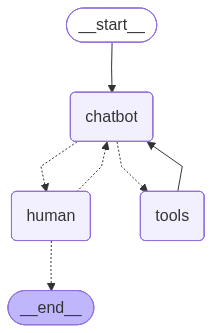

In [31]:
from langgraph.prebuilt import ToolNode

tools = [get_menu]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)


def maybe_route_to_tools(state: OrderState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"


def chatbot_with_tools(state: OrderState) -> OrderState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}


graph_builder = StateGraph(OrderState)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_menu = graph_builder.compile()

Image(graph_with_menu.get_graph().draw_mermaid_png())

In [32]:
state = graph_with_menu.invoke({"messages": []}, config)

Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?


User:  What options do you have for drinks?


Model: We have a variety of coffee and tea drinks, including espresso, americano, latte, cappuccino, and more. We also have tea drinks like English Breakfast, Green Tea, and Chai Latte. You can also add modifiers like different types of milk, espresso shots, sweeteners, and caffeine options.


User:  What options are there with milk?


Model: We have several coffee and tea drinks that come with milk, including Latte, Cappuccino, Cortado, Macchiato, Mocha, Flat White, Chai Latte, and Matcha Latte. You can also add milk to other drinks like tea or coffee.

For milk options, we offer Whole, 2%, Oat, Almond, and 2% Lactose Free. The default option is whole milk.


User:  q
